# Create a general MODFLOW model from the NHDPlus dataset

Project specific variables are imported in the model_spec.py and gen_mod_dict.py files that must be included in the notebook directory. The first first includes pathnames to data sources that will be different for each user. The second file includes a dictionary of model-specific information such as  cell size, default hydraulic parameter values, and scenario defintion (e.g. include bedrock, number of layers, etc.). There are examples in the repository. Run the following cells up to the "Run to here" cell to get a pull-down menu of models in the model_dict. Then, without re-running that cell, run all the remaining cells.  Re-running the following cell would re-set the model to the first one in the list, which you probably don't want. If you use the notebook option to run all cells below, it runs the cell you're in, so if you use that option, move to the next cell (below the pull-down menu of models) first.

In [1]:
__author__ = 'Jeff Starn'
%matplotlib notebook
from model_specs import *
from gen_mod_dict import *
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import flopy as fp
import pandas as pd
import gdal
gdal.UseExceptions()
import shutil

from copy import deepcopy
from ipywidgets import interact, Dropdown
from IPython.display import display

In [2]:
for key, value in model_dict.items():   # from "gen_mod_dict.py"
    md = key
    ms = model_dict[md]
    print('trying {}'.format(md))
    try:
        pass
    except:
        pass

trying Niantic
trying Niantic250
trying Assabet
trying CoastalCT
trying CoastalCT500
trying Niantic500


In [3]:
models = list(model_dict.keys())
models.sort()
model_area = Dropdown(
    options=models,
    description='Model:',
    background_color='cyan',
    border_color='black',
    border_width=2)
display(model_area)

### Run to here to initiate notebook

First time using this notebook in this session (before restarting the notebook), run the cells up to this point. Then select your model from the dropdown list above. Move your cursor to this cell and use the toolbar menu Cell --> Run All Below.  After the first time, if you want to run another model, select your model and start running from this cell--you don't need to re-run the cells from the beginning.

## Preliminary stuff

In [4]:
md = model_area.value
ms = model_dict[md]
print('The model being processed is {}\n'.format(md))

if 'L' in ms.keys():
    L = ms['L']

The model being processed is CoastalCT



Set pathnames and create workspace directories for geographic data (from Notebook 1) and this model.

In [5]:
label='RIV'

#other options: RIV, DeepBed, ShallowBed

In [6]:
if label!='':
    scenario_dir = scenario_dir+"_"+str(label)
geo_ws = os.path.join(proj_dir, ms['ws'])
model_ws = os.path.join(geo_ws, scenario_dir)
array_pth = os.path.join(model_ws, 'arrays')
    
try:
    shutil.rmtree(array_pth)
except:
    pass

try:
    shutil.rmtree(model_ws)
except:
    pass

if not os.path.isdir(model_ws):
    os.makedirs(model_ws)

head_file_name = '{}.hds'.format(md)
head_file_pth = os.path.join(model_ws, head_file_name)

print (model_ws)

C:/workspace/gw-general-models/Genmod1.0/subprojects/siteGeneral\CoastalCT\layers_GHB_sea_septic_RIV


Replace entries from the default K_dict with the model specific K values from model_dict if they exist. 

In [7]:
# from "gen_mod_dict.py"
for key, value in K_dict.items():
    if key in ms.keys():
        K_dict[key] = ms[key]

Replace entries from the default rock_riv_dict with the model specific values from model_dict if they exist. rock_riv_dict has various attributes of bedrock and stream geometry.

In [8]:
# from "gen_mod_dict.py"
for key, value in rock_riv_dict.items():
    if key in ms.keys():
        rock_riv_dict[key] = ms[key]

Assign values to variables used in this notebook using rock_riv_dict

In [9]:
min_thk = rock_riv_dict['min_thk'] 
stream_width = rock_riv_dict['stream_width'] 
stream_bed_thk = rock_riv_dict['stream_bed_thk']
river_depth = rock_riv_dict['river_depth'] 
bedrock_thk = rock_riv_dict['bedrock_thk']
# addition of stream_bed_kadjust factor by Leon Kauffman
stream_bed_kadjust = rock_riv_dict['stream_bed_kadjust']

#read in the marine boundary information
coastal_sed_kadjust = rock_riv_dict['coastal_sed_kadjust']
coastal_sed_thk = rock_riv_dict['coastal_sed_thk']

## Read the information for a model domain processed using Notebook 1

Read the model_grid data frame from a csv file. Extract grid dimensions and ibound array.

In [10]:
model_file = os.path.join(geo_ws, 'model_grid.csv')
model_grid = pd.read_csv(model_file, index_col='node_num', na_values=['nan', hnoflo])

NROW = model_grid.row.max() + 1
NCOL = model_grid.col.max() + 1
num_cells = NROW * NCOL

ibound = model_grid.ibound.values.reshape(NROW, NCOL)
inactive = (ibound == 0)

## Translate geologic information into hydrologic properties

Method for geology mapping to zone number from dataset GESS_poly.gdb in
"Glacial Environments and Surficial Sediments (GESS) Geodatabase for the Glaciated, Conterminous United States",
https://doi.org/10.5066/F71R6PQG

model_grid.gess_poly from CrseStratSed in GESS_poly.gdb = 0 represents fine sediments

model_grid.gess_poly from CrseStratSed in GESS_poly.gdb = 1 represents coarse sediments


Create a dictionary that maps the K_dict from gen_mod_dict to zone numbers (key=zone number, value=entry in K_dict).  Make sure these correspond with the correct units. If you're using the defaults, it is correct.

In [11]:
zone_dict = {0 : 'K_fine', 1 : 'K_coarse', 2 : 'K_lakes', 3 : 'K_bedrock'}

Perform the mapping from zone number to K to create the Kh1d array.

In [12]:
zones1d = np.zeros(( NROW, NCOL ), dtype=np.int32)

gess = model_grid.gess_poly.values.reshape( NROW, NCOL )
zones1d[gess == 0] = 0
zones1d[gess == 1] = 1
zones1d_noLakes = deepcopy(zones1d)

la = model_grid.lake.values.reshape( NROW, NCOL )
zones1d[la == 1] = 2

Kh1d = np.zeros(( NROW, NCOL ), dtype=np.float32)
Kh1d_noLakes = np.zeros(( NROW, NCOL ), dtype=np.float32)

for key, val in zone_dict.items():
    Kh1d[zones1d == key] = K_dict[val]
    Kh1d_noLakes[zones1d_noLakes == key] = K_dict[val]
    
model_grid['K0'] = Kh1d.ravel()
model_grid['K0_noLakes'] = Kh1d_noLakes.ravel()

## Process boundary condition information

Create a dictionary of stream information for the drain or river package.
River package input also needs the elevation of the river bed. Don't use both packages. The choice is made by commenting/uncommenting sections of the modflow function. Replace segment_len (segment length) with the conductance. The river package has not been tested.

In [13]:
#testing the use of drn for 1st to 5th order and riv for 6th order rivers
#& (model_grid.order<6)
if "RIV" in label:
    drn_flag = (pd.notnull(model_grid.stage)) & (model_grid.ibound == 1) & (model_grid.order<6)
else:
    drn_flag = (pd.notnull(model_grid.stage)) & (model_grid.ibound == 1)
drn_data = model_grid.loc[drn_flag, ['lay', 'row', 'col', 'stage', 'segment_len', 'K0_noLakes','arbolateSum']]
drn_data.columns = ['k', 'i', 'j', 'stage', 'segment_len', 'K0','arbolateSu']
# dcond = drn_data.K0 * drn_data.segment_len * stream_width / stream_bed_thk
# addition of stream_bed_kadjust factor by Leon Kauffman
# stream width based on relationship from NE streams in NWIS (UU:\R_Code\StreamwidthRelationship.r)
# math notes on 1/14/2020
stream_width = 0.8660592 * (drn_data.arbolateSu) **0.5511555
dcond = drn_data.K0 * stream_bed_kadjust * drn_data.segment_len * stream_width / stream_bed_thk 
drn_data['segment_len'] = dcond
drn_data.rename(columns={'segment_len' : 'cond'}, inplace=True)
drn_data.drop('K0', axis=1, inplace=True)
drn_data.drop('arbolateSu',axis=1, inplace=True)
drn_data.dropna(axis='index', inplace=True)
drn_data.insert(drn_data.shape[1], 'iface', 6)
drn_recarray = drn_data.to_records(index=False)
drn_dict = {0 : drn_recarray}

In [14]:
#testing adding a drain to wetlands and lakes
drn_flag = (model_grid.PerWater> 0) & (model_grid.ibound == 1) & (pd.isnull(model_grid.stage)) & (model_grid.ghb_sea==0)
drn_data = model_grid.loc[drn_flag, ['lay', 'row', 'col', 'top','K0_noLakes','PerWater']]
drn_data.columns = ['k', 'i', 'j', 'stage', 'K0','PerWater']

#adjust the stage to ensure it is below the land surface
drn_data.stage = np.around(np.floor(drn_data.stage*1000)/1000.0,decimals=3)

dcond = drn_data.K0 * stream_bed_kadjust * L*L *drn_data.PerWater/ stream_bed_thk 
drn_data['K0'] = dcond
drn_data['K0'] = drn_data['K0'].astype('float64')
drn_data.rename(columns={'K0' : 'cond'}, inplace=True)
drn_data.drop('PerWater', axis=1, inplace=True)
drn_data.dropna(axis='index', inplace=True)
drn_data.insert(drn_data.shape[1], 'iface', 6)
drn_recarray = drn_data.to_records(index=False)
drn_dict[0] = np.core.records.fromrecords((np.concatenate([drn_dict[0],drn_recarray], axis=0)), dtype=drn_recarray.dtype)

In [15]:
riv_flag = pd.notnull(model_grid.stage) & (model_grid.ibound == 1) & (model_grid.order>=6)
riv_data = model_grid.loc[riv_flag, ['lay', 'row', 'col', 'stage', 'segment_len', 'K0_noLakes','arbolateSum']]
riv_data.columns = ['k', 'i', 'j', 'stage', 'segment_len', 'K0','arbolateSu']
riv_data['rbot'] = riv_data.stage - river_depth
# stream width based on relationship from NE streams in NWIS (UU:\R_Code\StreamwidthRelationship.r)
stream_width = 0.3048 * 3.0 * (riv_data.arbolateSu) **0.54320
#rcond = riv_data.K0 * riv_data.segment_len * stream_width / stream_bed_thk
# addition of stream_bed_kadjust factor by Leon Kauffman
rcond = riv_data.K0 * stream_bed_kadjust * riv_data.segment_len * stream_width / stream_bed_thk
riv_data['segment_len'] = rcond
riv_data.rename(columns={'segment_len' : 'rcond'}, inplace=True)
riv_data.drop('K0', axis=1, inplace=True)
riv_data.drop('arbolateSu', axis=1, inplace=True)
riv_data.dropna(axis='index', inplace=True)
riv_data.insert(riv_data.shape[1], 'iface', 6)
riv_recarray = riv_data.to_records(index=False)
riv_dict = {0 : riv_recarray}

Create a dictionary of information for the general-head boundary package.
Similar to the above cell. Not tested.

In [16]:
if model_grid.ghb.sum() > 0:
    ghb_flag = model_grid.ghb == 1
    ghb_data = model_grid.loc[ghb_flag, ['lay', 'row', 'col', 'top', 'segment_len', 'K0_noLakes']]
    ghb_data.columns = ['k', 'i', 'j', 'stage', 'segment_len', 'K0']
    gcond = ghb_data.K0 * L * L / stream_bed_thk
    ghb_data['segment_len'] = gcond
    ghb_data.rename(columns={'segment_len' : 'cond'}, inplace=True)
    ghb_data.drop('K0', axis=1, inplace=True)
    ghb_data.dropna(axis='index', inplace=True)
    ghb_data.insert(ghb_data.shape[1], 'iface', 6)
    ghb_recarray = ghb_data.to_records(index=False)
    ghb_dict = {0 : ghb_recarray}

Create a dictionary for the marine general-head boundary.

In [17]:
if model_grid.ghb_sea.sum() > 0:
    #currently the marine ghb would overwrite any existing ghb, therefore write an alert
    if GHB & GHB_sea:
        GHB = False
        print("Code doesn't support multiple ghb's. Marine ghb will be implemented.")    
    ghb_flag = model_grid.ghb_sea == 1
    ghb_sea_data = model_grid.loc[ghb_flag, ['lay', 'row', 'col', 'fresh_head', 'segment_len', 'K0_noLakes','Coast_Shallow','Coast_Deep','WetlandPer']]
    ghb_sea_data.columns = ['k', 'i', 'j', 'stage', 'segment_len', 'K0','Coast_Shallow','Coast_Deep','WetlandPer']
    ghb_sea_data['Coast_All']=ghb_sea_data.Coast_Shallow + ghb_sea_data.Coast_Deep
    ghb_sea_data['Coast_Wetland']=np.minimum(ghb_sea_data.WetlandPer,ghb_sea_data.Coast_All)
    ghb_sea_data['Coast_nonWetland']=ghb_sea_data.Coast_All-ghb_sea_data.Coast_Wetland
    
    #multiplying the conductance by the coastal area and decreasing the conductance of coastal wetlands by 50%
    gcond = K_dict['K_streambed'] * L * L / coastal_sed_thk / coastal_sed_kadjust*(ghb_sea_data.Coast_nonWetland
    + 0.25*ghb_sea_data.Coast_Wetland)
    ghb_sea_data['segment_len'] = gcond
    ghb_sea_data.rename(columns={'segment_len' : 'cond'}, inplace=True)
    ghb_sea_data.drop('K0', axis=1, inplace=True)
    ghb_sea_data.drop('Coast_Shallow',axis=1,inplace=True)
    ghb_sea_data.drop('Coast_Deep',axis=1,inplace=True)
    ghb_sea_data.drop('WetlandPer',axis=1,inplace=True)
    ghb_sea_data.drop('Coast_All',axis=1,inplace=True)
    ghb_sea_data.drop('Coast_Wetland',axis=1,inplace=True)
    ghb_sea_data.drop('Coast_nonWetland',axis=1,inplace=True)
    ghb_sea_data.dropna(axis='index', inplace=True)
    ghb_sea_data.insert(ghb_sea_data.shape[1], 'iface', 6)
    ghb_sea_recarray = ghb_sea_data.to_records(index=False)
    ghb_sea_dict = {0 : ghb_sea_recarray}

Create a dictionary for septic systems.

In [18]:
if model_grid.sewer.sum() > 0:
    septic_flag = model_grid.sewer == 0
    septic_data = model_grid.loc[:, ['lay', 'row', 'col', 'population','sewer','PerWater']]
    septic_data.columns = ['k', 'i', 'j', 'population','sewer','PerWater']
    
    #use the percent water to adjust the population density
    septic_data['population'] = septic_data.population*(1-septic_data.PerWater)
    
    #set septic recharge to the top layer
    septic_data['k']=0
    septic_flux = septic_data.population*useResPerCap*(1-consumpRes)*(1-septic_data.sewer)
    septic_data['Q'] = septic_flux
    model_grid.loc[:, 'Septic_flux']=septic_flux
    #septic_data.drop('population', axis=1, inplace=True)
    #septic_data.dropna(axis='index', inplace=True)
    #septic_recarray = septic_data.to_records(index=False)

Create a dictionary for private wells.

In [19]:
if model_grid.pws.sum() > 0:
    well_flag = model_grid.pws == 0
    well_data = model_grid.loc[well_flag, ['lay', 'row', 'col', 'population','PerWater']]
    well_data.columns = ['k', 'i', 'j', 'population',"PerWater"]
    
    #use the percent water to adjust the population density
    well_data['population'] = well_data.population*(1-well_data.PerWater)
    
    #set well withdrawals to the bottom layer
    well_data['k']= num_surf_layers
    well_flux = well_data.population*useResPerCap
    well_data['Q'] = -1*well_flux #negative flux is pumping
    well_data.drop('population', axis=1, inplace=True)
    well_data.drop('PerWater', axis=1, inplace=True)
    well_data.dropna(axis='index', inplace=True)
    well_recarray = well_data.to_records(index=False)
    well_dict={0:well_recarray}
    #well_dict[0] = np.append(well_dict[0],well_recarray, axis=0) 

Create a dictionary for water supply wells.

In [20]:
if model_grid.well_PWSFlux.sum() != 0:
    well_flag = model_grid.well_PWSFlux != 0
    well_data = model_grid.loc[well_flag, ['lay', 'row', 'col', 'well_PWSFlux','well_APA']]
    well_data.columns = ['k', 'i', 'j', 'Q','well_APA']
    #set well withdrawals to the bottom layer (or the lowest surf layer if there is an APA)
    well_data['k']= num_surf_layers-well_data['well_APA'].astype('int64')
    well_data.drop('well_APA', axis=1, inplace=True)
    well_data.dropna(axis='index', inplace=True)
    well_recarray = well_data.to_records(index=False)
    #well_dict={0:well_recarray}
    well_dict[0] = np.append(well_dict[0],well_recarray, axis=0) 

Get starting heads from top elevations. The top is defined as the model-cell-mean NED elevation except in streams, where it is interpolated between MaxElevSmo and MinElevSmo in the NHD (called 'stage' in model_grid). Make them a little higher than land so that drains don't accidentally go dry too soon.

In [21]:
top = model_grid.top.values.reshape(NROW, NCOL)
strt = top * 1.05

Modify the bedrock surface, ensuring that it is always at least min_thk below the top elevation. This calculation will be revisited for the multi-layer case.

In [22]:
bedrock = model_grid.kauffman_bedrock_el.values.reshape(NROW, NCOL)
thick = model_grid.kauffman_CTquat_thk.values.reshape(NROW,NCOL)

thk = top - bedrock

if "ShallowBed" in label:
    thk = thk*0.5
    bedrock = top - thk
elif "DeepBed" in label:
    thk = thk*1.5
    bedrock = top - thk

thk[thk < min_thk] = min_thk
bot = top - thk

## Create recharge array

This version replaces the Wolock/Yager recharge grid and the Reitz grid with the SWB_NAWQA. An alternative recharge source can also be specified (Wolock).

In [23]:
## used in general models prior to 4/5/2016
# rech = model_grid.recharge.values.reshape(NROW, NCOL)

Replace rech array with
* calculate total recharge for the model domain
* calculate areas of fine and coarse deposits
* apportion recharge according to the ratio specified in gen_mod_dict.py
* write the values to an array

In [24]:
#Now using an alternate approach below
# r_SWB = model_grid.rch_eff_m_SWB_NAWQA.values.reshape(NROW, NCOL) / 365.25

# rech_ma = np.ma.MaskedArray(r_SWB, mask=inactive)
# coarse_ma = np.ma.MaskedArray(zones1d != 0, mask=inactive)
# fine_ma = np.ma.MaskedArray(zones1d == 0, mask=inactive)

# total_rech = rech_ma.sum()
# Af = fine_ma.sum()
# Ac = coarse_ma.sum()
# Rf = total_rech / (rech_fact * Ac + Af)
# Rc = rech_fact * Rf

# rech = np.zeros_like(r_SWB)
# rech[zones1d != 0] = Rc
# rech[zones1d == 0] = Rf

# model_grid['recharge'] = model_grid.rch_eff_m_SWB_NAWQA    
# model_grid.to_csv(os.path.join(model_ws, 'model_grid.csv'))

In [25]:
#this approach maintains the overall ratio of recharge between coarse and fine sediments AND keeps much of the spatial variation 
r_SWB = model_grid.rch_eff_m_SWB_NAWQA.values.reshape(NROW, NCOL) / 365.25

perDev = model_grid.PerDev.values.reshape(NROW, NCOL)

# r_SWB = r_SWB*(1-perDev)

#use the more details surficial zones for the recharge
SurfGeoArr = model_grid.SurfGeo.values.reshape( NROW, NCOL )
zones1d_detailed = np.ones(( NROW, NCOL ), dtype=np.int32)

#if alluvium, bedrock, artificial fill, marsh, fines, till or thick till (code 2, 3, 4, 7, 8,9, 10), then it's fine for recharge purposes, otherwise it's coarse
zones1d_detailed[((SurfGeoArr==2) | (SurfGeoArr==3) | (SurfGeoArr==4) | (SurfGeoArr==7) | (SurfGeoArr==8) | (SurfGeoArr==9) | (SurfGeoArr==10))]=0

#save the zones1d_detailed for use in calibration
if not os.path.isdir(os.path.join(model_ws,'arrays')):
    os.mkdir(os.path.join(model_ws,'arrays'))
np.savetxt(os.path.join(model_ws,'arrays','zones1d_detailed.ref'), zones1d_detailed)
np.savetxt(os.path.join(model_ws,'arrays','rech_base.ref'), r_SWB)
np.savetxt(os.path.join(model_ws,'arrays','PerDev.ref'), r_SWB)

rech_ma = np.ma.MaskedArray(r_SWB, mask=inactive)
coarse_ma = np.ma.MaskedArray(zones1d_detailed != 0, mask=inactive)
fine_ma = np.ma.MaskedArray(zones1d_detailed == 0, mask=inactive)

total_rech = rech_ma.sum()
Af = fine_ma.sum()
Ac = coarse_ma.sum()
Rf = total_rech / (rech_fact * Ac + Af)
Rc = rech_fact * Rf
R_meanC = np.mean(rech_ma[coarse_ma==1])
R_meanF = np.mean(rech_ma[fine_ma==1])
R_mean = np.mean(rech_ma)

rech = np.zeros_like(r_SWB)
rech[zones1d_detailed != 0] = r_SWB[zones1d_detailed !=0] * (Rc/R_meanC)
rech[zones1d_detailed == 0] = r_SWB[zones1d_detailed ==0] * (Rf/R_meanF)

# model_grid['recharge'] = model_grid.rch_eff_m_SWB_NAWQA*(1-model_grid.PerDev) 
model_grid['recharge'] = model_grid.rch_eff_m_SWB_NAWQA
model_grid.to_csv(os.path.join(model_ws, 'model_grid.csv'))

In [26]:
# r_Reitz = model_grid.rch_eff_m_Reitz_2013.values.reshape(NROW, NCOL) / 365.25

# rech_ma = np.ma.MaskedArray(r_Reitz, mask=inactive)
# coarse_ma = np.ma.MaskedArray(zones1d != 0, mask=inactive)
# fine_ma = np.ma.MaskedArray(zones1d == 0, mask=inactive)

# total_rech = rech_ma.sum()
# Af = fine_ma.sum()
# Ac = coarse_ma.sum()
# Rf = total_rech / (rech_fact * Ac + Af)
# Rc = rech_fact * Rf

# rech = np.zeros_like(r_Reitz)
# rech[zones1d != 0] = Rc
# rech[zones1d == 0] = Rf

# model_grid['recharge'] = model_grid.rch_eff_m_Reitz_2013    
# model_grid.to_csv(os.path.join(model_ws, 'model_grid.csv'))

In [27]:
##Alternative recharge, to use, comment-out the above cell and uncomment this cell
# r_Wolock = model_grid.rch_m_Wolock.values.reshape(NROW, NCOL) / 365.25

# rech_ma = np.ma.MaskedArray(r_Wolock, mask=inactive)
# coarse_ma = np.ma.MaskedArray(zones1d != 0, mask=inactive)
# fine_ma = np.ma.MaskedArray(zones1d == 0, mask=inactive)

# total_rech = rech_ma.sum()
# Af = fine_ma.sum()
# Ac = coarse_ma.sum()
# Rf = total_rech / (rech_fact * Ac + Af)
# Rc = rech_fact * Rf

# rech = np.zeros_like(r_Wolock)
# rech[zones1d != 0] = Rc
# rech[zones1d == 0] = Rf

# model_grid['recharge'] = model_grid.rch_m_Wolock    
# model_grid.to_csv(os.path.join(model_ws, 'model_grid.csv'))

add the septic return flows to the recharge

In [28]:
from scipy import stats
print(stats.describe(rech,axis=None))
rech[ibound==1].sum()

DescribeResult(nobs=250656, minmax=(0.0, 0.0053623893357188585), mean=0.0011494451233387709, variance=7.3274196166009802e-07, skewness=1.162190557802123, kurtosis=1.1504482773336075)


130.77252594528838

In [29]:
if septic_flux.sum()>0:
    septic_rech = septic_flux.values.reshape(NROW,NCOL)/L/L
    np.savetxt(os.path.join(model_ws,'arrays','septic_rech.ref'), septic_rech)
    rech = rech+septic_rech

## Define a function to create and run MODFLOW

In [30]:
def modflow(md, mfpth, model_ws, nlay=1, top=top, strt=strt, nrow=NROW, ncol=NCOL, botm=bedrock, 
            ibound=ibound, hk=Kh1d, rech=rech, stream_dict=drn_dict, riv_dict = riv_dict, delr=L, delc=L, 
            hnoflo=hnoflo, hdry=hdry, iphdry=1, laytyp=1):

    strt_dir = os.getcwd()
    os.chdir(model_ws)

    ml = fp.modflow.Modflow(modelname=md, exe_name=mfpth, version='mfnwt', 
                            external_path='arrays') 

    # add packages (DIS has to come before either BAS or the flow package)
    dis = fp.modflow.ModflowDis(ml, nlay=nlay, nrow=NROW, ncol=NCOL, nper=1, delr=L, delc=L, 
                                laycbd=0, top=top, botm=botm, perlen=1.E+05, nstp=1, tsmult=1, 
                                steady=True, itmuni=4, lenuni=2, extension='dis', 
                                unitnumber=11) 

    bas = fp.modflow.ModflowBas(ml, ibound=ibound, strt=strt, ifrefm=True, 
                                ixsec=False, ichflg=False, stoper=None, hnoflo=hnoflo, extension='bas', 
                                unitnumber=13)

    upw = fp.modflow.ModflowUpw(ml, laytyp=laytyp, layavg=0, chani=1.0, layvka=1, laywet=0, ipakcb=53, 
                                hdry=hdry, iphdry=iphdry, hk=hk, hani=1.0, vka=1.0, ss=1e-05, 
                                sy=0.15, vkcb=0.0, noparcheck=False, extension='upw', 
                                unitnumber=31)

    rch = fp.modflow.ModflowRch(ml, nrchop=3, ipakcb=53, rech=rech, irch=1, 
                                extension='rch', unitnumber=19)

    drn = fp.modflow.ModflowDrn(ml, ipakcb=53, stress_period_data=drn_dict, 
                                dtype=drn_dict[0].dtype,
                                extension='drn', unitnumber=21, options=['NOPRINT', 'AUX IFACE'])

    riv = fp.modflow.ModflowRiv(ml, ipakcb=53, stress_period_data=riv_dict, 
                                dtype=riv_dict[0].dtype,
                                extension='riv', unitnumber=18, options=['NOPRINT', 'AUX IFACE'])

    if GHB:
        ghb = fp.modflow.ModflowGhb(ml, ipakcb=53, stress_period_data=ghb_dict, 
                                dtype=ghb_dict[0].dtype,
                                extension='ghb', unitnumber=23, options=['NOPRINT', 'AUX IFACE'])
    if GHB_sea:
        ghb = fp.modflow.ModflowGhb(ml, ipakcb=53, stress_period_data=ghb_sea_dict, 
                                dtype=ghb_sea_dict[0].dtype,
                                extension='ghb', unitnumber=23, options=['NOPRINT', 'AUX IFACE'])
    if septic:
        thisWell = deepcopy(well_dict[0])
        #adjust the layers for the 1 layer model
        thisWell['k'][thisWell['k']>nlay]=nlay-1
        #only keep the rows with non-zero flow
        thisWell = thisWell[thisWell['Q']!=0]

        #aggregate wells that are in the same cells
        #convert array to df
        thisWell_df = pd.DataFrame(thisWell)
        thisWell_df = thisWell_df.groupby(['k','i','j']).sum().reset_index()
        thisWell = thisWell_df.to_records(index=False)
        well = fp.modflow.ModflowWel(ml, ipakcb=53,stress_period_data = {0:thisWell}, dtype=well_dict[0].dtype,extension='wel', options=["NOPRINT"])
        

    oc = fp.modflow.ModflowOc(ml, ihedfm=0, iddnfm=0, chedfm=None, cddnfm=None, cboufm=None, 
                              compact=True, stress_period_data={(0, 0): ['save head', 'save budget']}, 
                              extension=['oc', 'hds', 'ddn', 'cbc'], unitnumber=[14, 51, 52, 53])

#     nwt = fp.modflow.ModflowNwt(ml, headtol=0.0001, fluxtol=500, maxiterout=1000, 
#                                 thickfact=1e-05, linmeth=2, iprnwt=1, ibotav=0, options='COMPLEX')

# below was used prior to March 2018
#     nwt = fp.modflow.ModflowNwt(ml, headtol=0.0001, fluxtol=500, maxiterout=100, thickfact=1e-05, 
#                                 linmeth=2, iprnwt=1, ibotav=1, options='SPECIFIED', dbdtheta =0.80, 
#                                 dbdkappa = 0.00001, dbdgamma = 0.0, momfact =  0.10, backflag = 1, 
#                                 maxbackiter=30, backtol=1.05, backreduce=0.4, iacl=2, norder=1, 
#                                 level=3, north=7, iredsys=1, rrctols=0.0,idroptol=1, epsrn=1.0E-3,
#                                 hclosexmd= 1.0e-4, mxiterxmd=200)

#below reflects changes to make solving easier, March 2018
    nwt = fp.modflow.ModflowNwt(ml, headtol=0.0001, fluxtol=500, maxiterout=1000, thickfact=1e-05, 
                                linmeth=2, iprnwt=1, ibotav=1, options='SPECIFIED', dbdtheta =0.10, 
                                dbdkappa = 0.00001, dbdgamma = 0.01, momfact =  0.10, backflag = 1, 
                                maxbackiter=10, backtol=1.05, backreduce=0.4, iacl=2, norder=1, 
                                level=3, north=7, iredsys=1, rrctols=0.0,idroptol=1, epsrn=1.0E-3,
                                hclosexmd= 1.0e-4, mxiterxmd=200)

    ml.write_input()
    
    if not "RIV" in label:
        ml.remove_package('RIV')

        ml.write_input()
    success, output = ml.run_model(silent=True)
    os.chdir(strt_dir)
    if success:
        print("    Your {:0d} layer model ran successfully".format(nlay))
    else:
        print("    Your {:0d} layer model didn't work".format(nlay))

## Run 1-layer MODFLOW

Use the function to run MODFLOW for 1 layer to getting approximate top-of-aquifer elevation

In [31]:
modflow(md, mfpth, model_ws, nlay=1, top=top, strt=strt, nrow=NROW, ncol=NCOL, botm=bot, ibound=ibound, 
        hk=Kh1d, rech=rech, stream_dict=drn_dict, delr=L, delc=L, hnoflo=hnoflo, hdry=hdry, iphdry=0)

Note: external_path arrays already exists
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:vani layer 1: resetting 'how' to external
    Your 1 layer model ran successfully


Read the head file and calculate new layer top (wt) and bottom (bot) elevations based on the estimated
water table (wt) being the top of the top layer. Divide the surficial layer into NLAY equally thick layers between wt and the bedrock surface elevation (as computed using minimum surficial thickness). 

In [32]:
hdobj = fp.utils.HeadFile(head_file_pth)
heads1 = hdobj.get_data(kstpkper=(0, 0))
heads1[heads1 == hnoflo] = np.nan
heads1[heads1 <= hdry] = np.nan
heads1 = heads1[0, :, :]
hdobj = None

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


In [33]:
# thisRow = 264
# thisCol = 229
# ml = fp.modflow.Modflow.load('%s.nam'%(md),model_ws=model_ws)
# hdobj = fp.utils.HeadFile(head_file_pth)
# headsplot = hdobj.get_data(kstpkper=(0, 0))
# headsplot[headsplot == hnoflo] = np.nan
# headsplot[headsplot <= hdry] = np.nan
# fname = os.path.join(model_ws, '%s.cbc'%(md))
# cbb = fp.utils.CellBudgetFile(fname)
# frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
# fff = cbb.get_data(text='FLOW FRONT FACE')[0]
# fig = plt.figure(figsize=(10, 10))

# ax = fig.add_subplot(1, 1, 1, aspect='equal')
# ax.set_title('plot_array()')
# modelmap = fp.plot.ModelMap(model=ml, extent = ((thisCol-1)*L,(thisCol+2)*L,(NROW-thisRow-1)*L,(NROW-thisRow+2)*L))
# quadmesh = modelmap.plot_ibound()
# quadmesh = modelmap.plot_array(top, masked_values=[999.], alpha=0.5)
# # quadmesh = modelmap.plot_bc('DRN', color='purple')
# quadmesh = modelmap.plot_bc('WEL', color='navy')
# # quadmesh = modelmap.plot_bc('RIV', color='yellow')
# quiver = modelmap.plot_discharge(frf, fff, head=headsplot)
# linecollection = modelmap.plot_grid()

## Create layering using the scenario in gen_mod_dict

Make new model with (possibly) multiple layers. If there are dry cells in the 1 layer model, they are converted to NaN (not a number). The minimum function in the first line returns NaN if the element of either input arrays is NaN.  In that case, replace NaN in modeltop with the top elevation. The process is similar to the 1 layer case. Thickness is estimated based on modeltop and bedrock and is constrained to be at least min_thk (set in gen_mod_dict.py). This thickness is divided into num_surf_layers number of layers. The cumulative thickness of these layers is the distance from the top of the model to the bottom of the layers. This 3D array of distances (the same for each layer) is subtracted from modeltop.

Modflow adjusts the pumping from wells to prevent dewatering. In adjusting the model top to the water table elevation, we want those cells to reflect NaN (so the new model top is the current land surface).

In [34]:
#get the actual pumping rates
fname = os.path.join(model_ws, '%s.cbc'%(md))
cbb = fp.utils.CellBudgetFile(fname)
wellPumpDF = pd.DataFrame(cbb.get_data(text='WELLS')[0])
wellPumpDF.columns=['node_num','well_q']
#add 1 to the node to match the numbering in model_gri
wellPumpDF['node_num'] = wellPumpDF['node_num']-1
wellPumpDF.set_index('node_num', inplace=True)
#get the specified pumping and merge in the actual pumping
specifiedPump = model_grid[['row','col']]

#get the actual pumping and aggregate by row / col
pumpSpecs = pd.DataFrame(well_dict[0])
pumpSpecs.drop('k', axis=1,inplace=True)
pumpSpecs = pumpSpecs.groupby(['i','j']).sum().reset_index()

specifiedPump = specifiedPump.merge(pumpSpecs,"left",left_on=['row','col'],right_on=['i','j'])
specifiedPump = specifiedPump.merge(wellPumpDF,"left", left_index=True, right_index=True)
#switch 0 in the specified pumping rate to Nan
specifiedPump.loc[specifiedPump.Q==0,'Q']=np.nan
index = np.invert(np.isclose(specifiedPump.Q, specifiedPump.well_q,atol=0.1, rtol=0,equal_nan=True))
reducedPumping = index.reshape(NROW,NCOL)

#change the head in cells with reducing pumping to dry
heads1[reducedPumping]=np.nan

In [35]:
modeltop = np.minimum(heads1, top)
nan = np.isnan(heads1)
modeltop[nan] = top[nan]
thk = modeltop - bedrock
thk[thk < min_thk] = min_thk


NLAY = num_surf_layers
lay_extrude = np.ones((NLAY, NROW, NCOL))
lay_thk = lay_extrude * thk / NLAY
bot = modeltop - np.cumsum(lay_thk, axis=0)

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in minimum
  if __name__ == '__main__':


Using the estimated water table as the new top-of-aquifer elevations sometimes leads to the situation, in usually a very small number of cells, that the drain elevation is below the bottom of the cell.  The following procedure resets the bottom elevation to one meter below the drain elevation if that is the case. 

* If add_bedrock = True in gen_mod_dict.py, add a layer to the bottom and increment NLAY by 1.
* Assign the new bottom-most layer an elevation equal to the elevation of the bottom of the lowest surficial layer minus bedrock_thk, which is specified in rock_riv_dict (in gen_mod_dict.py).
* Concatenate the new bottom-of-bedrock-layer to the bottom of the surficial bottom array.
* Compute the vertical midpoint of each cell. Make an array (bedrock_index) that is True if the bedrock surface is higher than the midpoint and False if it is not.
* lay_extrude replaces the old lay_extrude to account for the new bedrock layer. It is not used in this cell, but is used later to extrude other arrays.

In [36]:
# sol_thk = model_grid.soller_thk.values.reshape(NROW, NCOL)
# tmp = top - sol_thk
# bedrock_4_K = bedrock.copy()
# bedrock_4_K[bedrock > top] = tmp[bedrock > top]

# if add_bedrock:
#     NLAY = num_surf_layers + 1
#     lay_extrude = np.ones((NLAY, NROW, NCOL))
#     bed_bot = bot[-1:,:,:] - bedrock_thk
#     bot = np.concatenate((bot, bed_bot), axis=0)

#     mids = bot + thk / NLAY / 2
#     bedrock_index = mids < bedrock_4_K
#     bedrock_index[-1:,:,:] = True

# elif not add_bedrock:
#     print('    no bedrock')
#     pass

# else:
#     print('    add_bedrock variable needs to True or False')

In [37]:
kauffman_CTquat_thk = model_grid.kauffman_CTquat_thk.values.reshape(NROW, NCOL)
tmp = top - kauffman_CTquat_thk
bedrock_4_K = bedrock.copy()
bedrock_4_K[bedrock > top] = tmp[bedrock > top]

if add_bedrock:
    NLAY = num_surf_layers + 1
    lay_extrude = np.ones((NLAY, NROW, NCOL))
    bed_bot = bot[-1:,:,:] - bedrock_thk
    bot = np.concatenate((bot, bed_bot), axis=0)

    mids = bot + thk / NLAY / 2
    bedrock_index = mids < bedrock_4_K
    bedrock_index[-1:,:,:] = True

elif not add_bedrock:
    print('    no bedrock')
    pass

else:
    print('    add_bedrock variable needs to True or False')

Extrude all arrays to NLAY number of layers. Create a top-of-aquifer elevation (fake_top) that is higher (20% in this case) than the simulated 1-layer water table because in doing this approximation, some stream elevations end up higher than top_of_aquifer and thus do not operate as drains. The fake_top shouldn't affect model computations if it is set high enough because the model uses convertible (confined or unconfined) layers.

In [38]:
fake_top = (modeltop+np.abs(modeltop)*0.2).astype(np.float32)
strt = (lay_extrude * modeltop * 1.05).astype(np.float32)
ibound = (lay_extrude * ibound).astype(np.int16)

Perform the mapping from zone number to K to create the Kh3d array.

In [39]:
#limit the fake_top to the height of the land surface (no higher)
fake_top = np.minimum(fake_top, top)

In [40]:
#actually we want the model top at the sea floor for the marine boundary
# #ensure the fake_top is above the marine boundaries
# fresh_head =  model_grid.fresh_head.values.reshape(NROW, NCOL)
# ghb_sea = model_grid.ghb_sea.values.reshape(NROW, NCOL)
# #use a really large number for the fresh head where there is no ghb_sea so the minimum is always the other
# fresh_head[ghb_sea==0]=-100000
# fake_top = np.maximum(fake_top,fresh_head)

In [41]:
#ensure the fake_top is above river boundaries
stage =  model_grid.stage.values.reshape(NROW, NCOL)

#use a really small number for the stage where there is no river so the maximum is always the other
stage[np.isnan(stage)]=-100000
fake_top = np.maximum(fake_top,stage)

In [42]:
zones3d = np.zeros(( NLAY, NROW, NCOL ), dtype=np.int32)

gess = model_grid.gess_poly.values.reshape(NROW, NCOL)
gess3d = (lay_extrude * gess).astype(np.int32)

zones3d[gess3d == 0] = 0
zones3d[gess3d == 1] = 1

if add_bedrock:
    zones3d[bedrock_index] = 3

la = model_grid.lake.values.reshape(NROW, NCOL)
zones3d[0, la == 1] = 2

Kh3d = np.zeros(( NLAY, NROW, NCOL ), dtype=np.float32)

for key, val in zone_dict.items():
    Kh3d[zones3d == key] = K_dict[val]

Run MODFLOW again using the new layer definitions.  The difference from the first run is that the top-of-aquifer elevation is the 1-layer water table rather than land surface, and of course, the number of surficial layers and/or the presence of a bedrock layer is different. 

In [43]:
if bedConfined:
    laytypeLst = [1]*(NLAY-1)
    laytypeLst.append(0)
else:
    laytypeLst=1
modflow(md, mfpth, model_ws, nlay=NLAY, top=fake_top, strt=strt, nrow=NROW, ncol=NCOL, 
        botm=bot, ibound=ibound, hk=Kh3d, rech=rech, stream_dict=drn_dict, delr=L, 
        delc=L, hnoflo=hnoflo, hdry=hdry, iphdry=1, laytyp=laytypeLst)

Note: external_path arrays already exists
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:vani layer 1: resetting 'how' to external
Util2d:vani layer 2: resetting 'how' to external
Util2d:vani layer 3: resetting 'how' to external
Util2d:vani layer 4: resetting 'how' to external
    Your 4 layer model ran successfully


Read the new head array

In [44]:
hdobj = fp.utils.HeadFile(head_file_pth)
heads = hdobj.get_data()
hdobj = None

Make a 2D array of the heads in the highest active cells and call it the water_table

In [45]:
heads[heads == hnoflo] = np.nan
heads[heads <= hdry] = np.nan
hin = np.argmax(np.isfinite(heads), axis=0)
row, col = np.indices((hin.shape))
water_table = heads[hin, row, col]

water_table_ma = np.ma.MaskedArray(water_table, inactive)

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app


Save the head array to a geotiff file.

In [46]:
data = water_table_ma

src_pth = os.path.join(geo_ws, 'ibound.tif')
src = gdal.Open(src_pth)

dst_pth = os.path.join(model_ws, 'pre-heads.tif')
driver = gdal.GetDriverByName('GTiff')
dst = driver.CreateCopy(dst_pth, src, 0)

band = dst.GetRasterBand(1)
band.WriteArray(data)
band.SetNoDataValue(np.nan)

dst = None
src = None

Save the heads and K from the upper-most layer to model_grid.csv

In [47]:
model_grid['pre_cal_heads'] = water_table_ma.ravel()
model_grid['pre_cal_K'] = Kh3d[0,:,:].ravel()

if add_bedrock:
    model_grid['thk'] = model_grid.top - bot[-1,:,:].ravel() + bedrock_thk
else:
    model_grid['thk'] = model_grid.top - bot[-1,:,:].ravel()

model_grid['thkR'] = model_grid.thk / model_grid.recharge
    
model_grid.to_csv(os.path.join(model_ws, 'model_grid.csv'))

Save zone array for use in calibration.

In [48]:
zone_file = os.path.join(model_ws, 'zone_array.npz')
np.savez(zone_file, zone=zones3d)

make a second zone array with more details surficial and bedrock geology

In [49]:
zones3d_detailed = deepcopy(zones3d)
surf_detailed = model_grid.SurfGeo.values.reshape(NROW, NCOL)
bedrock_geo = model_grid.BedLithSimp.values.reshape(NROW,NCOL)
zones3d_bedrock = deepcopy(zones3d_detailed)
zones3d_bedrock[zones3d_bedrock!=3]=0
zones3d_bedrock[zones3d_bedrock!=0]=1

zones3d_surf = deepcopy(zones3d_detailed)
zones3d_surf[zones3d_surf!=3]=1
zones3d_surf[zones3d_surf==3]=0


zones3d_surf = zones3d_surf * surf_detailed
zones3d_bedrock = zones3d_bedrock * bedrock_geo

#switch the "bedrock" zone in the surficial layers to the appropriate type
for i in range(NLAY):
    zones3d_surf[i][zones3d_surf[i]==4] = zones3d_bedrock[3][zones3d_surf[i]==4] 

#switch the "unconsolidated" zone in the bedrock layers to the appropriate type
# for i in range(NLAY):
#     zones3d_bedrock[i] [zones3d_bedrock[i]==2000] = zones3d_surf[0][zones3d_bedrock[i]==2000]

zones3d_detailed = zones3d_surf + zones3d_bedrock

#add in the lakes
la = model_grid.lake.values.reshape(NROW, NCOL)
zones3d_detailed [0][la == 1] = 2300

zone_file = os.path.join(model_ws, 'zone_array_detailed.npz')
np.savez(zone_file, zone=zones3d_detailed)

Plot a cross-section to see what the layers look like.  Change row_to_plot to see other rows.  Columns could be easily added.

In [50]:
def calc_error(top, head, obs_type):
    # an offset of 1 is used to eliminate counting heads that
    # are within 1 m of their target as errors.
    # count topo and hydro errors
    t = top < (head - err_tol)
    h = top > (head + err_tol)

    tmp_df = pd.DataFrame({'head':head, 'ot':obs_type, 't':t, 'h':h})

    tmp = tmp_df.groupby('ot').sum()
    h_e_ = tmp.loc['hydro', 'h']
    t_e_ = tmp.loc['topo', 't']
    result = np.array([h_e_, t_e_])
    return result

In [51]:
hydro, topo = calc_error(model_grid.top, water_table.ravel(), model_grid.obs_type)
num_hydro = model_grid.obs_type.value_counts()['hydro']
num_topo = model_grid.obs_type.value_counts()['topo']
num_cells = num_hydro + num_topo
hydro = hydro / num_hydro
topo = topo / num_topo

<IPython.core.display.Javascript object>


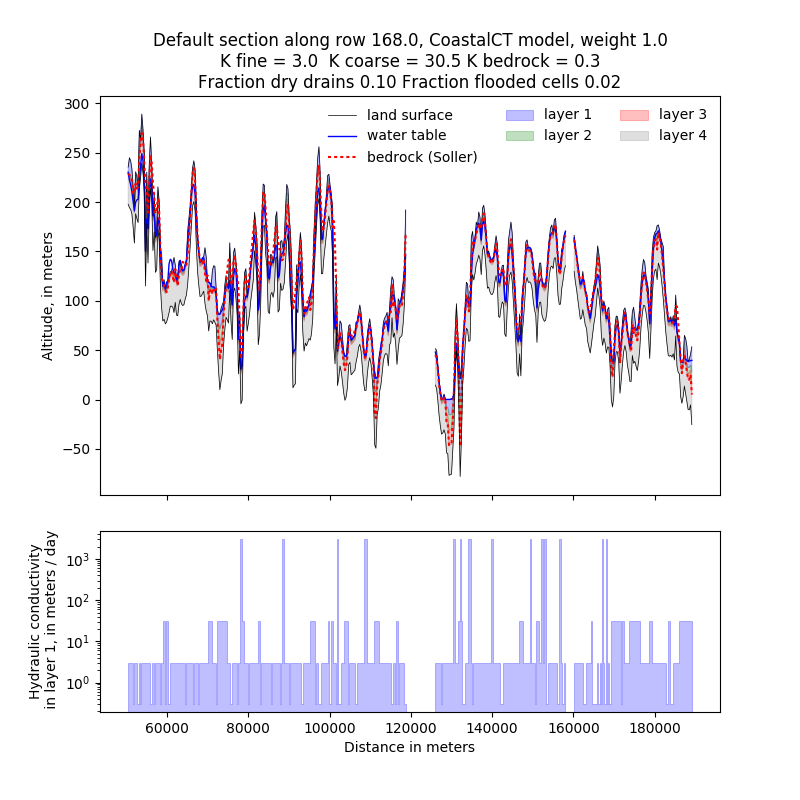

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\numpy\ma\core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\numpy\ma\core.py:3213: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]


In [52]:
def ma2(data2D):
    return np.ma.MaskedArray(data2D, mask=inactive)

def ma3(data3D):
    return np.ma.MaskedArray(data3D, mask=(ibound == 0))

row_to_plot = NROW / 2
xplot = np.linspace( L / 2, NCOL * L - L / 2, NCOL)

mKh = ma3(Kh3d)
mtop = ma2(top)
mbed = ma2(bedrock)
mbot = ma3(bot)

colors = ['green', 'red', 'gray']

fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot(xplot, mtop[row_to_plot, ], label='land surface', color='black', lw=0.5)
ax1.plot(xplot, water_table_ma[row_to_plot, ], label='water table', color='blue', lw=1.)
ax1.fill_between(xplot, mtop[row_to_plot, ], mbot[0, row_to_plot, :], alpha=0.25, 
                 color='blue', label='layer 1', lw=0.75)
for lay in range(NLAY-1):
    label = 'layer {}'.format(lay+2)
    ax1.fill_between(xplot, mbot[lay, row_to_plot, :], mbot[lay+1, row_to_plot, :], label=label, 
                    color=colors[lay], alpha=0.250, lw=0.75)
ax1.plot(xplot, mbed[row_to_plot, :], label='bedrock (Soller)', color='red', linestyle='dotted', lw=1.5)
ax1.plot(xplot, mbot[-1, row_to_plot, :], color='black', linestyle='solid', lw=0.5)
ax1.legend(loc=0, frameon=False, fontsize=10, ncol=3)#, bbox_to_anchor=(1.0, 0.5))
ax1.set_ylabel('Altitude, in meters')
ax1.set_xticklabels('')
ax1.set_title('Default section along row {}, {} model, weight {:0.1f}\nK fine = {:0.1f}  K coarse = {:0.1f}\
 K bedrock = {:0.1f}\nFraction dry drains {:0.2f} Fraction flooded cells {:0.2f}'.format(row_to_plot, \
 md, 1,  K_dict['K_fine'], K_dict['K_coarse'], K_dict['K_bedrock'], hydro, topo))

ax2 = plt.subplot2grid((3, 1), (2, 0))
ax2.fill_between(xplot, 0, mKh[0, row_to_plot, :], alpha=0.25, color='blue', 
                 label='layer 1', lw=0.75, step='mid')
ax2.set_xlabel('Distance in meters')
ax2.set_yscale('log')
ax2.set_ylabel('Hydraulic conductivity\n in layer 1, in meters / day')

line = '{}_{}_xs.png'.format(md, scenario_dir)
fig_name = os.path.join(model_ws, line)
plt.savefig(fig_name)

In [53]:
t = top < (water_table - err_tol)
h = top > (water_table + err_tol)

mt = np.ma.MaskedArray(t.reshape(NROW, NCOL), model_grid.obs_type != 'topo')
mh = np.ma.MaskedArray(h.reshape(NROW, NCOL), model_grid.obs_type != 'hydro')

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


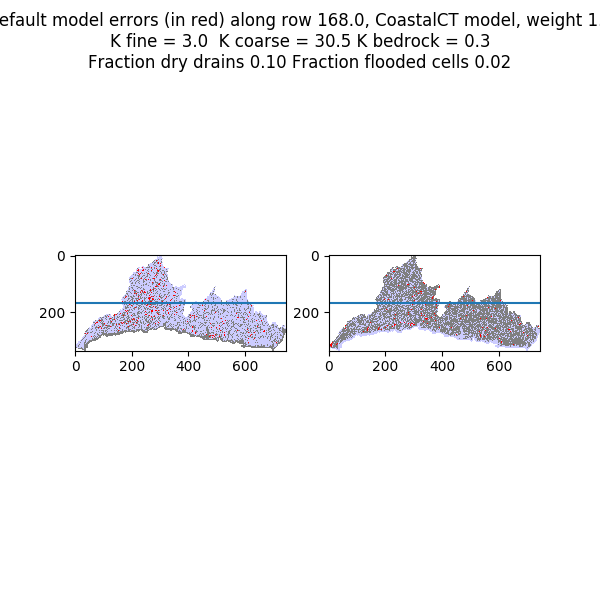

In [54]:
from matplotlib import colors

cmap = colors.ListedColormap(['0.50', 'red'])
cmap2 = colors.ListedColormap(['blue'])

back = np.ma.MaskedArray(ibound[0,:,:], ibound[0,:,:] == 0)
fig, ax = plt.subplots(1,2)
ax[0].imshow(back, cmap=cmap2, alpha=0.2)
im0 = ax[0].imshow(mh, cmap=cmap, interpolation='None')
ax[0].axhline(row_to_plot)
# fig.colorbar(im0, ax=ax[0])
ax[1].imshow(back, cmap=cmap2, alpha=0.2)
im1 = ax[1].imshow(mt, cmap=cmap, interpolation='None')
ax[1].axhline(row_to_plot)
# fig.colorbar(im1, ax=ax[1])
fig.suptitle('Default model errors (in red) along row {}, {} model, weight {:0.1f}\nK fine = {:0.1f}  K coarse = {:0.1f}\
 K bedrock = {:0.1f}\nFraction dry drains {:0.2f} Fraction flooded cells {:0.2f}'.format(row_to_plot, \
 md, 1.0, K_dict['K_fine'], K_dict['K_coarse'], K_dict['K_bedrock'], hydro, topo))

# fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
#                       wspace=None, hspace=None)

fig.set_size_inches(6, 6)

# line = '{}_{}_error_map_cal.png'.format(md, scenario_dir)
line = '{}_{}_error_map.png'.format(md, scenario_dir)   #csc
fig_name = os.path.join(model_ws, line)
plt.savefig(fig_name)

In [55]:
ml = fp.modflow.Modflow.load('%s.nam'%(md),model_ws=model_ws)
fname = os.path.join(model_ws, '%s.cbc'%(md))
cbb = fp.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]
flf = cbb.get_data(text='FLOW LOWER FACE')[0]

hdobj = fp.utils.HeadFile(head_file_pth)
heads1 = hdobj.get_data(kstpkper=(0, 0))
heads1[heads1 == hnoflo] = np.nan
heads1[heads1 <= hdry] = np.nan

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in less_equal


<IPython.core.display.Javascript object>


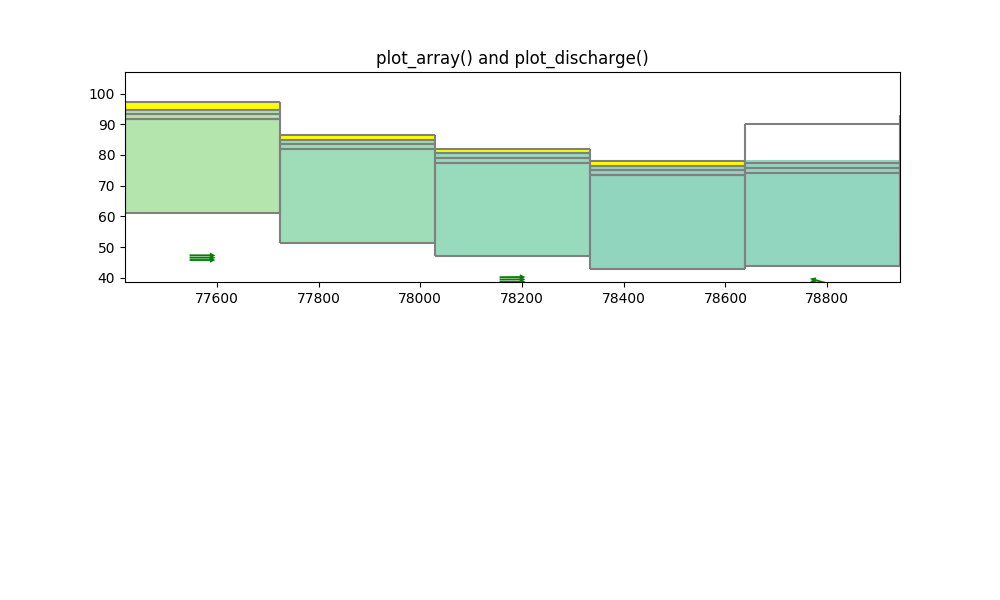

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\flopy\plot\crosssection.py:888: RuntimeWarning: invalid value encountered in less
  idx = v < e


In [56]:

thisCol = 616
startRow = 254
endRow = 258
ymax = np.nanmax(top[startRow:(endRow+1),thisCol])+0.1*np.abs(np.nanmax(top[startRow:(endRow+1),thisCol]))
ymin = np.nanmin(bot[-1,startRow:(endRow+1),thisCol])-0.1*np.abs(np.nanmin(bot[-1,startRow:(endRow+1),thisCol]))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(2, 1, 1)
ax.set_title('plot_array() and plot_discharge()')
modelxsect = fp.plot.ModelCrossSection(model=ml, ax=ax, line={'Column': thisCol}, extent=( startRow*L,(endRow+1)*L,ymin,ymax))
csa = modelxsect.plot_array(heads1, masked_values=[999.], head=heads1, alpha=0.5)
linecollection = modelxsect.plot_grid()
quiver = modelxsect.plot_discharge(frf, fff, flf=flf, head=heads1, 
                                   hstep=2, normalize=True, color='green', 
                                   scale=30, headwidth=3, headlength=3, headaxislength=3,
                                   zorder=10)
# patches = modelxsect.plot_ibound(head=heads1)
# patches = modelxsect.plot_bc('WEL') #red
try:
    patches = modelxsect.plot_bc('RIV') #green
except:
        pass
patches = modelxsect.plot_bc('DRN') #yellow


<IPython.core.display.Javascript object>


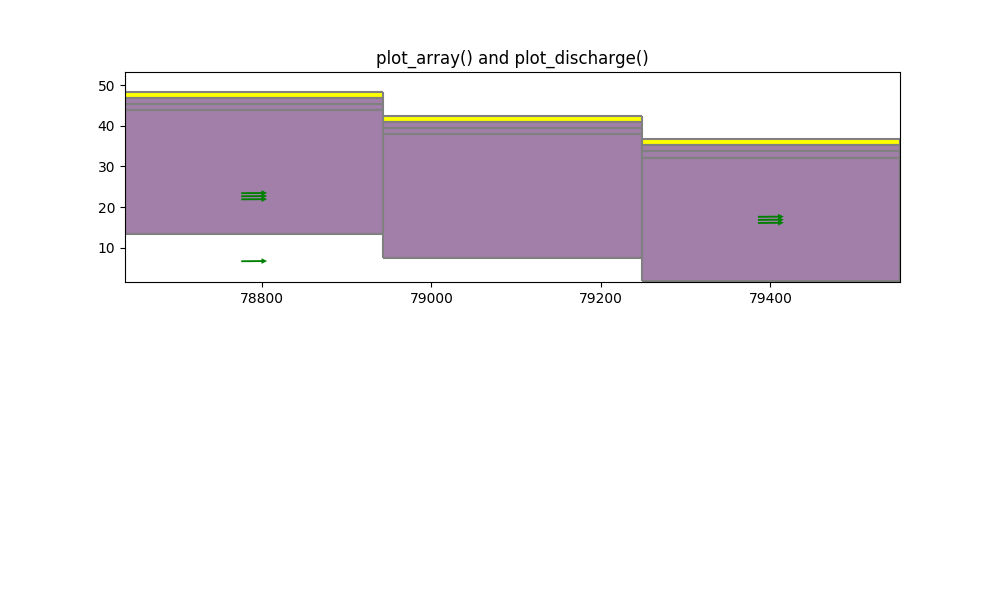

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\flopy\plot\crosssection.py:888: RuntimeWarning: invalid value encountered in less
  idx = v < e


In [57]:

thisCol = 420
startRow = 258
endRow = 260
ymax = np.nanmax(top[startRow:(endRow+1),thisCol])+0.1*np.abs(np.nanmax(top[startRow:(endRow+1),thisCol]))
ymin = np.nanmin(bot[-1,startRow:(endRow+1),thisCol])-0.1*np.abs(np.nanmin(bot[-1,startRow:(endRow+1),thisCol]))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(2, 1, 1)
ax.set_title('plot_array() and plot_discharge()')
modelxsect = fp.plot.ModelCrossSection(model=ml, ax=ax, line={'Column': thisCol}, extent=( startRow*L,(endRow+1)*L,ymin,ymax))
csa = modelxsect.plot_array(Kh3d, masked_values=[999.], head=heads1, alpha=0.5)
linecollection = modelxsect.plot_grid()
quiver = modelxsect.plot_discharge(frf, fff, flf=flf, head=heads1, 
                                   hstep=2, normalize=True, color='green', 
                                   scale=30, headwidth=3, headlength=3, headaxislength=3,
                                   zorder=10)
# patches = modelxsect.plot_ibound(head=heads1)
# patches = modelxsect.plot_bc('WEL') #red
try:
    patches = modelxsect.plot_bc('RIV') #green
except:
        pass
patches = modelxsect.plot_bc('DRN') #yellow


<IPython.core.display.Javascript object>


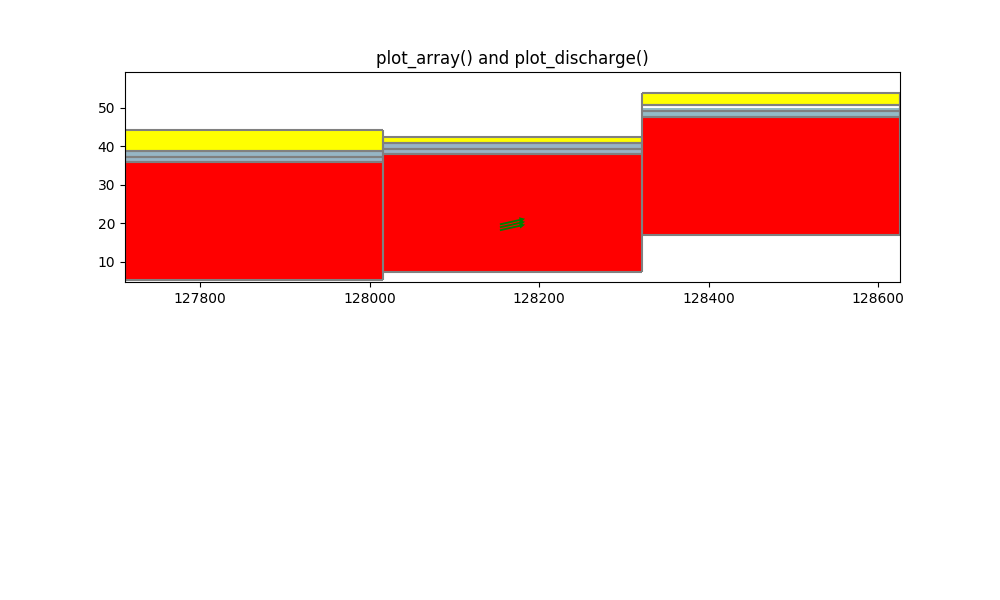

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\flopy\plot\crosssection.py:888: RuntimeWarning: invalid value encountered in less
  idx = v < e


In [58]:

thisRow = 259
startCol = 419
endCol = 421
ymax = np.nanmax(top[thisRow,startCol:(endCol+1)])+0.1*np.abs(np.nanmax(top[thisRow,startCol:(endCol+1)]))
ymin = np.nanmin(bot[-1,thisRow,startCol:(endCol+1)])-0.1*np.abs(np.nanmin(bot[-1,thisRow,startCol:(endCol+1)]))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(2, 1, 1)
ax.set_title('plot_array() and plot_discharge()')
modelxsect = fp.plot.ModelCrossSection(model=ml, ax=ax, line={'Row': thisRow}, extent=( startCol*L,(endCol+1)*L,ymin,ymax))
csa = modelxsect.plot_array(heads1, masked_values=[999.], head=heads1, alpha=0.5)
linecollection = modelxsect.plot_grid()
quiver = modelxsect.plot_discharge(frf, fff, flf=flf, head=heads1, 
                                   hstep=2, normalize=True, color='green', 
                                   scale=30, headwidth=3, headlength=3, headaxislength=3,
                                   zorder=10)
patches = modelxsect.plot_ibound(head=heads1)
patches = modelxsect.plot_bc('WEL') #red
try:
    patches = modelxsect.plot_bc('RIV') #green
except:
    pass
patches = modelxsect.plot_bc('DRN') #yellow


C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in less_equal


<IPython.core.display.Javascript object>


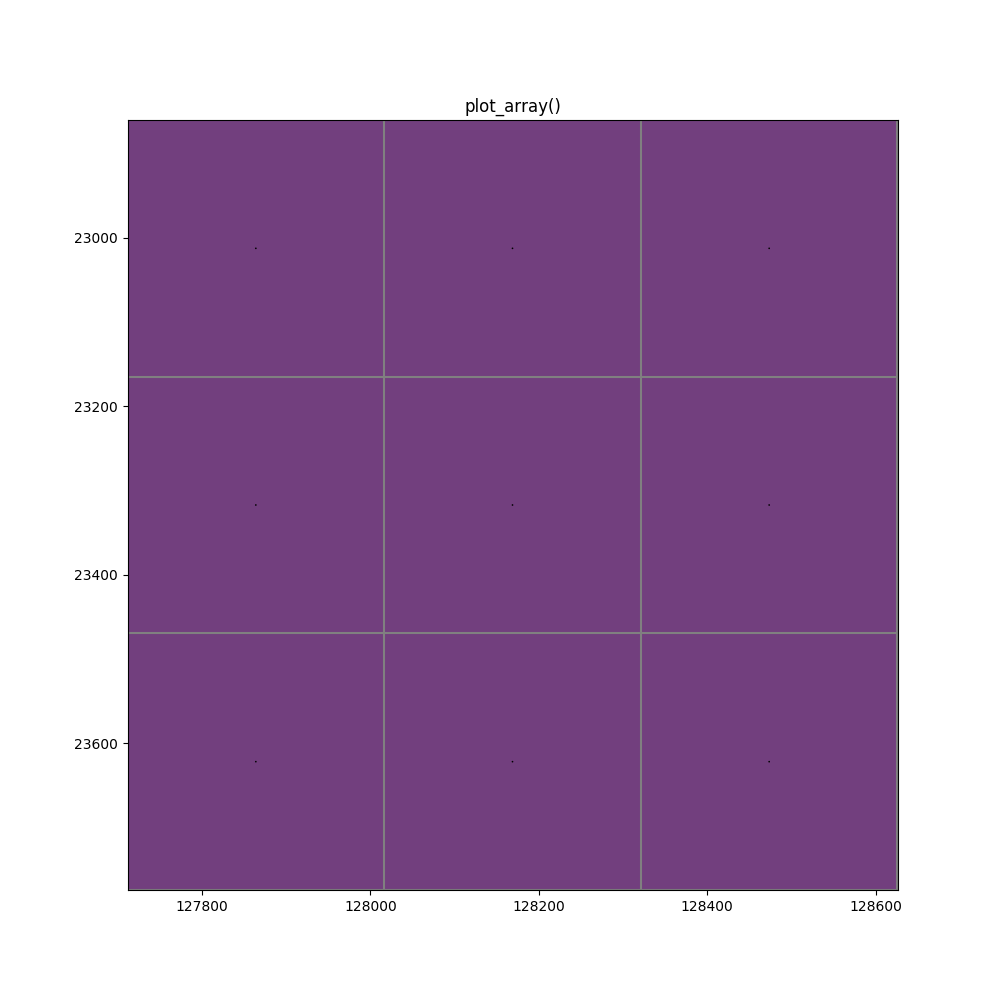

In [59]:
thisRow = 259
thisCol = 420
ml = fp.modflow.Modflow.load('%s.nam'%(md),model_ws=model_ws)
hdobj = fp.utils.HeadFile(head_file_pth)
headsplot = hdobj.get_data(kstpkper=(0, 0))
headsplot[headsplot == hnoflo] = np.nan
headsplot[headsplot <= hdry] = np.nan
fname = os.path.join(model_ws, '%s.cbc'%(md))
cbb = fp.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('plot_array()')
modelmap = fp.plot.ModelMap(model=ml, extent = ((thisCol-1)*L,(thisCol+2)*L,(NROW - thisRow+1)*L,(NROW - thisRow-2)*L), layer = 0)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(headsplot, masked_values=[999.], alpha=0.5)
# quadmesh = modelmap.plot_bc('DRN', color='purple')
quadmesh = modelmap.plot_bc('WEL', color='navy')
# quadmesh = modelmap.plot_bc('RIV', color='yellow')
quiver = modelmap.plot_discharge(frf, fff,flf=flf, head=headsplot)
linecollection = modelmap.plot_grid()

In [60]:
Drn = cbb.get_data(text=b' DRAINS')[0]
Drn_DF = pd.DataFrame(Drn)

In [61]:
model_grid.columns

Index(['ibound', 'SHEDS', 'arbolateSu', 'gess_poly', 'lake',
       'kauffman_CTquat_thk', 'HUC12_shortCD', 'HUC12_shortCD_ext', 'sewer',
       'pws', 'well_PWSFlux', 'well_APA', 'BedLithSimp', 'SurfGeo',
       'embayment', 'ned', 'ned_mean', 'kauffman_bedrock_el', 'slope',
       'ned_coast_min', 'catchment', 'soller_thk', 'soller_bedrock_el', 'nlcd',
       'clear', 'clear_per_grass', 'nlcd_ag', 'WetlandPer', 'PerDev',
       'population', 'rch_eff_m_SWB_NAWQA', 'rch_eff_m_Reitz_2013',
       'rch_m_Wolock', 'Coast_Deep', 'Coast_Shallow', 'PerWater', 'PerSand',
       'PerClay', 'PerSilt', 'NDep_dry', 'NDep_wet', 'edge', 'ghb', 'stage',
       'segment_len', 'order', 'arbolateSum', 'reachcode', 'reach_intermit',
       'reach_len', 'reach_int', 'ghb_sea', 'fresh_head', 'top', 'lay', 'row',
       'col', 'obs_type', 'xc', 'yc', 'K0', 'K0_noLakes', 'Septic_flux',
       'recharge', 'pre_cal_heads', 'pre_cal_K', 'thk', 'thkR'],
      dtype='object')

In [62]:
model_grid.iloc[210090]

ibound                           1
SHEDS                        90935
arbolateSu                       0
gess_poly                        0
lake                             0
kauffman_CTquat_thk          45.72
HUC12_shortCD                   73
HUC12_shortCD_ext               73
sewer                            0
pws                              0
well_PWSFlux                     0
well_APA                         0
BedLithSimp                   1600
SurfGeo                          8
embayment                        0
ned                      0.0535225
ned_mean                     0.711
kauffman_bedrock_el       -45.6665
slope                      1.38053
ned_coast_min                0.711
catchment              1.86018e+06
soller_thk                 22.8774
soller_bedrock_el         -18.4905
nlcd                            95
clear                            7
clear_per_grass                  0
nlcd_ag                          0
WetlandPer                    0.45
PerDev              